In [174]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [175]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [176]:
# get the total os classes
# specify the CSV file path
csv_file_path = "model/keypoint_classifier/keypoint_classifier_label.csv"


with open(csv_file_path, "r") as file: # open the CSV file in read mode
    line_count = 0
    for line in file:
        line_count += 1

classes_names = line_count + 1

In [177]:
# number os classes are the total in classes file
NUM_CLASSES = 10

# Dataset reading

In [178]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [179]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [181]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [182]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                860       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [183]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [184]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [185]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/13 [=>............................] - ETA: 8s - loss: 2.5566 - accuracy: 0.0391
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==============================] - 1s 16ms/step - loss: 2.5326 - accuracy: 0.0321 - val_loss: 2.3682 - val_accuracy: 0.0481
Epoch 2/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.4534 - accuracy: 0.0156
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==============================] - 0s 6ms/step - loss: 2.3939 - accuracy: 0.0401 - val_loss: 2.2631 - val_accuracy: 0.0500
Epoch 3/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.3254 - accuracy: 0.0469
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
13/13 [==============================] - 0s 7ms/step - loss: 2.3089 - accuracy: 0.0519 - val_loss: 2.1948 - val_accuracy: 0.0481
Epoch 4/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.2740 - accuracy: 0.0703


In [186]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 3ms/step - loss: 0.4058 - accuracy: 0.9000


In [187]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [188]:
# Inference test
predict_result = model.predict(np.array([X_test[0]])) #type:ignore
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 66ms/step
[8.6804563e-01 7.3134552e-09 1.6686466e-02 5.9097508e-13 3.6406759e-06
 3.4301924e-03 3.1231137e-04 1.0639953e-01 4.9553583e-03 1.6686473e-04]
0


# Confusion matrix

17/17 [==============================] - 0s 1ms/step


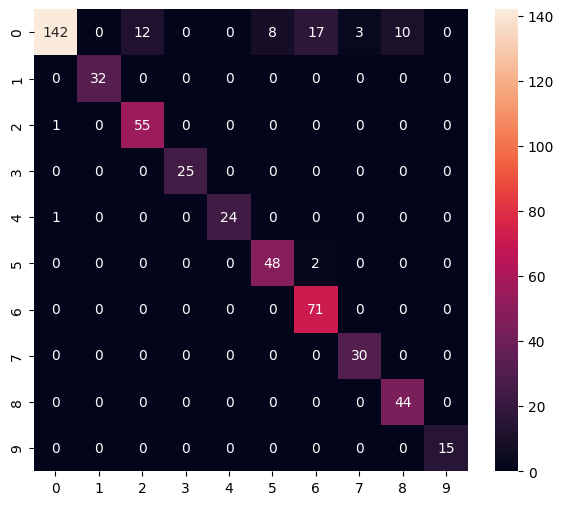

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       192
           1       1.00      1.00      1.00        32
           2       0.82      0.98      0.89        56
           3       1.00      1.00      1.00        25
           4       1.00      0.96      0.98        25
           5       0.86      0.96      0.91        50
           6       0.79      1.00      0.88        71
           7       0.91      1.00      0.95        30
           8       0.81      1.00      0.90        44
           9       1.00      1.00      1.00        15

    accuracy                           0.90       540
   macro avg       0.92      0.96      0.94       540
weighted avg       0.92      0.90      0.90       540



In [189]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test) #type: ignore
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [190]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False) #type: ignore

In [191]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #type: ignore
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\z003yt8j\AppData\Local\Temp\tmpjpxvtr9l\assets


INFO:tensorflow:Assets written to: C:\Users\z003yt8j\AppData\Local\Temp\tmpjpxvtr9l\assets


6872

# Inference test

In [192]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [193]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [194]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [195]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [196]:
print(np.squeeze(tflite_results)) #type: ignore
print(np.argmax(np.squeeze(tflite_results))) #type: ignore

[8.6804551e-01 7.3134387e-09 1.6686458e-02 5.9097285e-13 3.6406684e-06
 3.4301952e-03 3.1231152e-04 1.0639954e-01 4.9553607e-03 1.6686454e-04]
0
